# Gathering and Preparing Data for the Project

In [1]:
import pandas as pd
import csv

The table of toronto neighborhoods is available at https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

This table has been converted into a pandas datframe below: 


In [2]:
df=pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')

In [3]:
print(df[0])

    Postal Code           Borough  \
0           M1A      Not assigned   
1           M2A      Not assigned   
2           M3A        North York   
3           M4A        North York   
4           M5A  Downtown Toronto   
..          ...               ...   
175         M5Z      Not assigned   
176         M6Z      Not assigned   
177         M7Z      Not assigned   
178         M8Z         Etobicoke   
179         M9Z      Not assigned   

                                          Neighborhood  
0                                         Not assigned  
1                                         Not assigned  
2                                            Parkwoods  
3                                     Victoria Village  
4                            Regent Park, Harbourfront  
..                                                 ...  
175                                       Not assigned  
176                                       Not assigned  
177                                       

In [4]:
df1=pd.DataFrame()

In [5]:
df1.insert(0,'Postal Code',df[0]['Postal Code'])
df1.insert(1,'Borough',df[0]['Borough'])
df1.insert(2,'Neighborhood',df[0]['Neighborhood'])

In [6]:
df1.reset_index()
df1.head(10)

Postal Code           Borough                                 Neighborhood
0         M1A      Not assigned                                 Not assigned
1         M2A      Not assigned                                 Not assigned
2         M3A        North York                                    Parkwoods
3         M4A        North York                             Victoria Village
4         M5A  Downtown Toronto                    Regent Park, Harbourfront
5         M6A        North York             Lawrence Manor, Lawrence Heights
6         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government
7         M8A      Not assigned                                 Not assigned
8         M9A         Etobicoke      Islington Avenue, Humber Valley Village
9         M1B       Scarborough                               Malvern, Rouge

Dropping rows with Na values:

In [7]:
df1.drop(df1[df1.Borough=='Not assigned'].index,inplace=True)


In [8]:

#df1=df1.drop('Unnamed: 0.1',axis=1)
df1.head(10)

Postal Code           Borough                                 Neighborhood
2          M3A        North York                                    Parkwoods
3          M4A        North York                             Victoria Village
4          M5A  Downtown Toronto                    Regent Park, Harbourfront
5          M6A        North York             Lawrence Manor, Lawrence Heights
6          M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government
8          M9A         Etobicoke      Islington Avenue, Humber Valley Village
9          M1B       Scarborough                               Malvern, Rouge
11         M3B        North York                                    Don Mills
12         M4B         East York              Parkview Hill, Woodbine Gardens
13         M5B  Downtown Toronto                     Garden District, Ryerson

In [9]:
df1.loc[df1['Neighborhood']=='Not assigned','Neighborhood']=df1.Borough

In [10]:
df1=df1.reset_index(drop=True)
df1=df1.drop(df1.index[11])# drop this row since foursquare returns no venues for this
df1=df1.reset_index(drop=True)
df1.head(10)

Postal Code           Borough                                 Neighborhood
0         M3A        North York                                    Parkwoods
1         M4A        North York                             Victoria Village
2         M5A  Downtown Toronto                    Regent Park, Harbourfront
3         M6A        North York             Lawrence Manor, Lawrence Heights
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government
5         M9A         Etobicoke      Islington Avenue, Humber Valley Village
6         M1B       Scarborough                               Malvern, Rouge
7         M3B        North York                                    Don Mills
8         M4B         East York              Parkview Hill, Woodbine Gardens
9         M5B  Downtown Toronto                     Garden District, Ryerson

In [11]:
df1.shape

(102, 3)

In [12]:
!conda install -c conda-forge geopy --yes

Solving environment: done

# All requested packages already installed.



import Nominatim to find coordinates of neighborhoods:

In [13]:
from geopy.geocoders import Nominatim

In [14]:
df1['latitude']=""
df1['longitude']=""


After Cleaning the data and dropping rows whose coordinates could not be find by using Nominatim Package, a csv file 'Toronto_areas' was created. Can be accesed below:-

In [15]:
df1=pd.read_csv('Data/Toronto_areas.csv',header=0)


The code below finds the coordinates of the neighborhoods and adds them to the data frame. The process might take a few minutes.


In [16]:
for nd in df1['Neighborhood']:
    address=nd.split(',')[0]+",Toronto"
    geolocator = Nominatim(user_agent="toronto")
    location = geolocator.geocode(address)
    df1.loc[df1['Neighborhood'].str.contains(nd.split(',')[0]),'latitude']=location.latitude
    df1.loc[df1['Neighborhood'].str.contains(nd.split(',')[0]),'longitude']=location.longitude

In [17]:
df1=df1.drop('Unnamed: 0',axis=1)


In [18]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df1['Borough'].unique()),
        df1.shape[0]
    )
)

The dataframe has 9 boroughs and 99 neighborhoods.


In [19]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="-")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geographical coordinates of Toronto are 43.6534817, -79.3839347.


# Visualisation of the selected neighborhood using Folium:

In [20]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium


Solving environment: done

# All requested packages already installed.



# Visualising Toronto Neighborhoods

In [21]:
Toronto_map=folium.Map(location=[latitude,longitude],zoom_start=10)
for lat, lng, borough, neighborhood in zip(df1['latitude'], df1['longitude'], df1['Borough'],df1['Neighborhood']):
    label = '{},{}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.4,
        parse_html=False).add_to(Toronto_map)  
    
Toronto_map


Foursquare API has been used to get Venues Data. The API credentials are listed below.


In [22]:
import requests
from pandas.io.json import json_normalize 
CLIENT_ID = 'QXPPBDMPWTHSFATQGXNDG3SFDXEAR1K52Z1HF4BPMHCY4LDI' 
CLIENT_SECRET = 'UK0B3LTBOZD50XOUZSCEQCFXHUBCHDVJK5JCYUTAANEENHPO' 
#VERSION = '20180605' # Foursquare API version
VERSION = '20200101'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QXPPBDMPWTHSFATQGXNDG3SFDXEAR1K52Z1HF4BPMHCY4LDI
CLIENT_SECRET:UK0B3LTBOZD50XOUZSCEQCFXHUBCHDVJK5JCYUTAANEENHPO


# API Call:

In [23]:
radius=30000 #distance in metres around location (range)
Limit=500 #search results max
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude, 
            radius, 
            Limit)
results = requests.get(url).json()


In [24]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) #convert the json response to a pandas DataFrame
nearby_venues.reset_index()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


index                       referralId  reasons.count  \
0       0   e-0-5227bb01498e17bf485e6202-0              0   
1       1   e-0-4ad4c062f964a520b5f720e3-1              0   
2       2   e-0-55a9c018498e8b05f7f870f1-2              0   
3       3   e-0-4ad4c05ef964a520daf620e3-3              0   
4       4   e-0-5a81ae339deb7d369fa7f146-4              0   
..    ...                              ...            ...   
95     95  e-0-4bb75e0f6edc76b03212321c-95              0   
96     96  e-0-53b8466a498e83df908c3f21-96              0   
97     97  e-0-55637f1c498ecfe4c5dd2322-97              0   
98     98  e-0-4b9333f1f964a520fa3a34e3-98              0   
99     99  e-0-593b43e3e185f37c5a529082-99              0   

                                        reasons.items  \
0   [{'summary': 'This spot is popular', 'type': '...   
1   [{'summary': 'This spot is popular', 'type': '...   
2   [{'summary': 'This spot is popular', 'type': '...   
3   [{'summary': 'This spot is popular', 'type': '...   
4   [{'summary': 'This spot is popular', 'type': '...   
..                                                ...   
95  [{'summary': 'This spot is popular', 'type': '...   
96  [{'summary': 'This spot is popular', 'type': '...   
97  [{'summary': 'This spot is popular', 'type': '...   
98  [{'summary': 'This spot is popular', 'type': '...   
99  [{'summary': 'This spot is popular', 'type': '...   

                    venue.id                        venue.name  \
0   5227bb01498e17bf485e6202                  Downtown Toronto   
1   4ad4c062f964a520b5f720e3  Elgin And Winter Garden Theatres   
2   55a9c018498e8b05f7f870f1                               Alo   
3   4ad4c05ef964a520daf620e3            Art Gallery of Ontario   
4   5a81ae339deb7d369fa7f146                     Hailed Coffee   
..                       ...                               ...   
95  4bb75e0f6edc76b03212321c                     Serano Bakery   
96  53b8466a498e83df908c3f21                     Tandem Coffee   
97  55637f1c498ecfe4c5dd2322                     Boxcar Social   
98  4b9333f1f964a520fa3a34e3                   Coronation Park   
99  593b43e3e185f37c5a529082                  Tennessee Tavern   

    venue.location.lat  venue.location.lng  \
0            43.653232          -79.385296   
1            43.653394          -79.378507   
2            43.648574          -79.396243   
3            43.654003          -79.392922   
4            43.658833          -79.383684   
..                 ...                 ...   
95           43.683139          -79.346531   
96           43.653559          -79.361809   
97           43.659723          -79.346871   
98           43.634553          -79.405403   
99           43.639971          -79.439874   

                        venue.location.labeledLatLngs  \
0   [{'label': 'display', 'lat': 43.65323167517444...   
1   [{'label': 'display', 'lat': 43.65339379601958...   
2   [{'label': 'display', 'lat': 43.64857357946059...   
3   [{'label': 'display', 'lat': 43.65400286033738...   
4   [{'label': 'display', 'lat': 43.65883296982352...   
..                                                ...   
95  [{'label': 'display', 'lat': 43.68313941878674...   
96  [{'label': 'display', 'lat': 43.65355870959944...   
97  [{'label': 'display', 'lat': 43.65972274135156...   
98  [{'label': 'display', 'lat': 43.63455322391303...   
99  [{'label': 'display', 'lat': 43.63997128734775...   

    venue.location.distance  ... venue.location.country  \
0                       113  ...                 Canada   
1                       437  ...                 Canada   
2                      1131  ...                 Canada   
3                       726  ...                 Canada   
4                       596  ...                 Canada   
..                      ...  ...                    ...   
95                     4468  ...                 Canada   
96                     1782  ...                 Canada   
97                     3

# Cleaning the above DataFrame 


In [25]:
newDf_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, newDf_columns]
nearby_venues['venue.categories'] = nearby_venues.apply(lambda x: x['venue.categories'][0]['name'], axis=1)


In [26]:
nearby_venues.head()

venue.name   venue.categories  venue.location.lat  \
0                  Downtown Toronto       Neighborhood           43.653232   
1  Elgin And Winter Garden Theatres            Theater           43.653394   
2                               Alo  French Restaurant           43.648574   
3            Art Gallery of Ontario        Art Gallery           43.654003   
4                     Hailed Coffee        Coffee Shop           43.658833   

   venue.location.lng  
0          -79.385296  
1          -79.378507  
2          -79.396243  
3          -79.392922  
4          -79.383684

As you can see, only 100 venues were returned when you search the whole of Toronto.
To solve this, a function 'getNearbyVenues()' is made to loop through all the neighborhoods in the data frame and return venues:

In [29]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
    
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            Limit)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        for v in results:
            venues_list.append([
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']])
    return venues_list

The function above returns a list of venues and their coordinates. A data frame can be made from the list. 
Assign the list to toronto_venue:
P.S the process will take a few minutes

In [30]:
toronto_venue = getNearbyVenues(names=df1['Neighborhood'],
                                   latitudes=df1['latitude'],
                                   longitudes=df1['longitude']
                                  )

Make a data frame name 'nearby_venue' from the list:

In [31]:
nearby_venue=pd.DataFrame(toronto_venue, columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category'])

In [32]:
nearby_venue.shape


(5499, 7)

In [33]:
nearby_venue.head(10)

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Parkwoods                43.7588              -79.320197   
1    Parkwoods                43.7588              -79.320197   
2    Parkwoods                43.7588              -79.320197   
3    Parkwoods                43.7588              -79.320197   
4    Parkwoods                43.7588              -79.320197   
5    Parkwoods                43.7588              -79.320197   
6    Parkwoods                43.7588              -79.320197   
7    Parkwoods                43.7588              -79.320197   
8    Parkwoods                43.7588              -79.320197   
9    Parkwoods                43.7588              -79.320197   

             Venue  Venue Latitude  Venue Longitude  \
0  Allwyn's Bakery       43.759840       -79.324719   
1             LCBO       43.757774       -79.314257   
2      Tim Hortons       43.760668       -79.326368   
3        Dollarama       43.758135       -79.310672   
4              A&W       43.760643       -79.326865   
5      Tim Hortons       43.758295       -79.312310   
6    China Cottage       43.759097       -79.310419   
7          Staples       43.758379       -79.310695   
8      Tim Hortons       43.752814       -79.314067   
9           Subway       43.758073       -79.312235   

                  Venue Category  
0           Caribbean Restaurant  
1                   Liquor Store  
2                           Café  
3                 Discount Store  
4           Fast Food Restaurant  
5                    Coffee Shop  
6               Hakka Restaurant  
7  Paper / Office Supplies Store  
8                    Coffee Shop  
9                 Sandwich Place

In [34]:
nearby_venue.to_csv(r'allVenues.csv')

# Visualization of Venues

In [35]:
map_of_venues = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label in zip(nearby_venue['Venue Latitude'], nearby_venue['Venue Longitude'], nearby_venue['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_of_venues)  
    
map_of_venues

As is evident from the map, most venues in the city are concentrated in and around Downtown Toronto and along Bloor Street. 

Neighborhoods grouped by venues below:


In [36]:
venues_grouped_by_neighborhood=nearby_venue.groupby('Neighborhood').count()

venues_grouped_by_neighborhood.head(10)

Neighborhood Latitude  \
Neighborhood                                                             
 Willowdale East                                                    95   
Agincourt                                                           37   
Ancaster                                                            22   
Bathurst Manor, Wilson Heights, Downsview North                     16   
Bayview Village                                                     50   
Beaches                                                             87   
Bedford Park, Lawrence Manor East                                   63   
Berczy Park                                                        100   
Birch Cliff                                                         10   
Brockton, Parkdale Village, Exhibition Place                       100   

                                                 Neighborhood Longitude  \
Neighborhood                                                              
 Willowdale East                                                     95   
Agincourt                                                            37   
Ancaster                                                             22   
Bathurst Manor, Wilson Heights, Downsview North                      16   
Bayview Village                                                      50   
Beaches                                                              87   
Bedford Park, Lawrence Manor East                                    63   
Berczy Park                                                         100   
Birch Cliff                                                          10   
Brockton, Parkdale Village, Exhibition Place                        100   

                                                 Venue  Venue Latitude  \
Neighborhood                                                             
 Willowdale East                                    95              95   
Agincourt                                           37              37   
Ancaster                                            22              22   
Bathurst Manor, Wilson Heights, Downsview North     16              16   
Bayview Village                                     50              50   
Beaches                                             87              87   
Bedford Park, Lawrence Manor East                   63              63   
Berczy Park                                        100             100   
Birch Cliff                                         10              10   
Brockton, Parkdale Village, Exhibition Place       100             100   

                                                 Venue Longitude  \
Neighborhood                                                       
 Willowdale East                                              95   
Agincourt                                                     37   
Ancaster                                                      22   
Bathurst Manor, Wilson Heights, Downsview North               16   
Bayview Village                                               50   
Beaches                                                       87   
Bedford Park, Lawrence Manor East                             63   
Berczy Park                                                  100   
Birch Cliff                                                   10   
Brockton, Parkdale Village, Exhibition Place                 100   

                                                 Venue Category  
Neighborhood                                                     
 Willowdale East                                             95  
Agincourt                                                    37  
Ancaster                                                     22  
Bathurst Manor, Wilson Heights, Downsview North              16  
Bayview Village                                              50  
Beaches                                                      87  
Bedford Park, Lawrence Ma

In [37]:
print('There are {} uniques categories of venues in the city!!.'.format(len(nearby_venue['Venue Category'].unique())))

There are 324 uniques categories of venues in the city!!.


In [51]:
toronto_onehot = pd.get_dummies(nearby_venue[['Venue Category']],prefix="",prefix_sep="")
toronto_onehot['Neighborhood']=nearby_venue['Neighborhood']
toronto_onehot.head()

Accessories Store  Afghan Restaurant  African Restaurant  Airport  \
0                  0                  0                   0        0   
1                  0                  0                   0        0   
2                  0                  0                   0        0   
3                  0                  0                   0        0   
4                  0                  0                   0        0   

   American Restaurant  Amphitheater  Animal Shelter  Antique Shop  Aquarium  \
0                    0             0               0             0         0   
1                    0             0               0             0         0   
2                    0             0               0             0         0   
3                    0             0               0             0         0   
4                    0             0               0             0         0   

   Arcade  ...  Video Store  Vietnamese Restaurant  Warehouse Store  \
0       0  ...            0                      0                0   
1       0  ...            0                      0                0   
2       0  ...            0                      0                0   
3       0  ...            0                      0                0   
4       0  ...            0                      0                0   

   Whisky Bar  Wine Bar  Wine Shop  Wings Joint  Women's Store  \
0           0         0          0            0              0   
1           0         0          0            0              0   
2           0         0          0            0              0   
3           0         0          0            0              0   
4           0         0          0            0              0   

   Xinjiang Restaurant  Yoga Studio  
0                    0            0  
1                    0            0  
2                    0            0  
3                    0            0  
4                    0            0  

[5 rows x 324 columns]

In [39]:
col_list = list(toronto_onehot.columns)
col_list.remove('Neighborhood')
cols = ['Neighborhood'] + [col for col in col_list]
toronto_onehot = toronto_onehot[cols]
toronto_onehot.head(10)

Neighborhood  Accessories Store  Afghan Restaurant  African Restaurant  \
0    Parkwoods                  0                  0                   0   
1    Parkwoods                  0                  0                   0   
2    Parkwoods                  0                  0                   0   
3    Parkwoods                  0                  0                   0   
4    Parkwoods                  0                  0                   0   
5    Parkwoods                  0                  0                   0   
6    Parkwoods                  0                  0                   0   
7    Parkwoods                  0                  0                   0   
8    Parkwoods                  0                  0                   0   
9    Parkwoods                  0                  0                   0   

   Airport  American Restaurant  Amphitheater  Animal Shelter  Antique Shop  \
0        0                    0             0               0             0   
1        0                    0             0               0             0   
2        0                    0             0               0             0   
3        0                    0             0               0             0   
4        0                    0             0               0             0   
5        0                    0             0               0             0   
6        0                    0             0               0             0   
7        0                    0             0               0             0   
8        0                    0             0               0             0   
9        0                    0             0               0             0   

   Aquarium  ...  Video Store  Vietnamese Restaurant  Warehouse Store  \
0         0  ...            0                      0                0   
1         0  ...            0                      0                0   
2         0  ...            0                      0                0   
3         0  ...            0                      0                0   
4         0  ...            0                      0                0   
5         0  ...            0                      0                0   
6         0  ...            0                      0                0   
7         0  ...            0                      0                0   
8         0  ...            0                      0                0   
9         0  ...            0                      0                0   

   Whisky Bar  Wine Bar  Wine Shop  Wings Joint  Women's Store  \
0           0         0          0            0              0   
1           0         0          0            0              0   
2           0         0          0            0              0   
3           0         0          0            0              0   
4           0         0          0            0              0   
5           0         0          0            0              0   
6           0         0          0            0              0   
7           0         0          0            0              0   
8           0         0          0            0              0   
9           0         0          0            0              0   

   Xinjiang Restaurant  Yoga Studio  
0                    0            0  
1                    0            0  
2                    0            0  
3                    0            0  
4                    0            0  
5                    0            0  
6                    0            0  
7                    0            0  
8                    0            0  
9                    0            0  

[10 rows x 324 columns]

In [52]:

toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

Neighborhood  Accessories Store  \
0                                  Willowdale East                0.0   
1                                        Agincourt                0.0   
2                                         Ancaster                0.0   
3  Bathurst Manor, Wilson Heights, Downsview North                0.0   
4                                  Bayview Village                0.0   

   Afghan Restaurant  African Restaurant   Airport  American Restaurant  \
0                0.0                 0.0  0.000000             0.010526   
1                0.0                 0.0  0.000000             0.000000   
2                0.0                 0.0  0.045455             0.000000   
3                0.0                 0.0  0.000000             0.062500   
4                0.0                 0.0  0.000000             0.000000   

   Amphitheater  Animal Shelter  Antique Shop  Aquarium  ...  Video Store  \
0           0.0             0.0           0.0       0.0  ...          0.0   
1           0.0             0.0           0.0       0.0  ...          0.0   
2           0.0             0.0           0.0       0.0  ...          0.0   
3           0.0             0.0           0.0       0.0  ...          0.0   
4           0.0             0.0           0.0       0.0  ...          0.0   

   Vietnamese Restaurant  Warehouse Store  Whisky Bar  Wine Bar  Wine Shop  \
0               0.000000         0.000000         0.0       0.0        0.0   
1               0.027027         0.000000         0.0       0.0        0.0   
2               0.045455         0.045455         0.0       0.0        0.0   
3               0.000000         0.000000         0.0       0.0        0.0   
4               0.000000         0.000000         0.0       0.0        0.0   

   Wings Joint  Women's Store  Xinjiang Restaurant  Yoga Studio  
0          0.0            0.0                  0.0     0.010526  
1          0.0            0.0                  0.0     0.000000  
2          0.0            0.0                  0.0     0.000000  
3          0.0            0.0                  0.0     0.000000  
4          0.0            0.0                  0.0     0.000000  

[5 rows x 324 columns]

# The most popular venues in each neighborhood:

In [41]:
for area in toronto_grouped['Neighborhood']:
    print("_____"+area+"_____")
    temp_df = toronto_grouped[toronto_grouped['Neighborhood'] == area].T.reset_index()
    temp_df.columns = ['venue','freq']
    temp_df = temp_df.iloc[1:] #to exclude index col
    temp_df['freq'] = temp_df['freq'].astype(float)
    temp_df = temp_df.round({'freq': 2})
    print(temp_df.sort_values('freq', ascending=False).reset_index(drop=True).head(5))
    print('\n\n')



_____ Willowdale East_____
                  venue  freq
0           Coffee Shop  0.13
1         Grocery Store  0.04
2   Japanese Restaurant  0.04
3                  Bank  0.04
4  Fast Food Restaurant  0.03



_____Agincourt_____
                  venue  freq
0    Chinese Restaurant  0.24
1         Shopping Mall  0.08
2            Restaurant  0.05
3  Cantonese Restaurant  0.05
4                   Gym  0.03



_____Ancaster_____
                venue  freq
0                Park  0.09
1         Coffee Shop  0.09
2  Turkish Restaurant  0.09
3             Airport  0.05
4     Fireworks Store  0.05



_____Bathurst Manor, Wilson Heights, Downsview North_____
                       venue  freq
0         Athletics & Sports  0.12
1       Gym / Fitness Center  0.06
2  Middle Eastern Restaurant  0.06
3        Sporting Goods Shop  0.06
4             Sandwich Place  0.06



_____Bayview Village_____
                    venue  freq
0  Furniture / Home Store  0.08
1                    Café  0.06
2   

              venue  freq
0       Coffee Shop  0.11
1              Café  0.06
2  Sushi Restaurant  0.05
3       Pizza Place  0.05
4               Pub  0.05



_____Scarborough Town Centre,Dorset Park, Wexford Heights_____
                       venue  freq
0  Middle Eastern Restaurant  0.14
1                Pizza Place  0.11
2              Grocery Store  0.05
3               Intersection  0.05
4           Asian Restaurant  0.05



_____Scarborough Village_____
                  venue  freq
0           Coffee Shop  0.16
1               Theater  0.11
2  Fast Food Restaurant  0.11
3        Discount Store  0.05
4         Grocery Store  0.05



_____Silver Hills_____
                    venue  freq
0             Coffee Shop  0.20
1  Furniture / Home Store  0.20
2           Train Station  0.07
3          Discount Store  0.07
4              Restaurant  0.07



_____South Steeles, Silverstone, Humbergate, Jamestown, Mount Olive, Beaumond Heights, Thistletown, Albion Gardens_____
              

# Dataframe with the top 10 venues in each neighborhood:

In [42]:
import numpy as np


ordinals = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(10):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1,ordinals[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']


        
for ind in np.arange(toronto_grouped.shape[0]):
    row=toronto_grouped.iloc[ind, :]
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    neighborhoods_venues_sorted.iloc[ind, 1:] = row_categories_sorted.index.values[0:10]

neighborhoods_venues_sorted.head()

Neighborhood   1st Most Common Venue  \
0                                  Willowdale East             Coffee Shop   
1                                        Agincourt      Chinese Restaurant   
2                                         Ancaster                    Park   
3  Bathurst Manor, Wilson Heights, Downsview North      Athletics & Sports   
4                                  Bayview Village  Furniture / Home Store   

  2nd Most Common Venue     3rd Most Common Venue      4th Most Common Venue  \
0                  Bank       Japanese Restaurant              Grocery Store   
1         Shopping Mall      Cantonese Restaurant                 Restaurant   
2    Turkish Restaurant               Coffee Shop  Latin American Restaurant   
3  Gym / Fitness Center  Mediterranean Restaurant             Sandwich Place   
4                  Café               Coffee Shop             Clothing Store   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0        Sandwich Place  Fast Food Restaurant      Ramen Restaurant   
1                 Hotel          Noodle House     Korean Restaurant   
2     Electronics Store    Italian Restaurant    Chinese Restaurant   
3            Shoe Store     French Restaurant     Recreation Center   
4                  Bank         Moving Target    Chinese Restaurant   

  8th Most Common Venue      9th Most Common Venue 10th Most Common Venue  
0           Pizza Place  Middle Eastern Restaurant       Sushi Restaurant  
1           Karaoke Bar                Gas Station                   Bank  
2     Other Repair Shop               Intersection                   Café  
3      Basketball Court                Coffee Shop            Gas Station  
4          Liquor Store       Fast Food Restaurant                    Spa

# Standardise the Data

In [43]:
from sklearn.preprocessing import MinMaxScaler
df=toronto_grouped.drop('Neighborhood',axis=1)
scaler =MinMaxScaler()
X = scaler.fit_transform(df)

# Finding appropriate number of clusters

# Elbow Method

In [44]:
from sklearn.cluster import KMeans
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, tol=0.0001,  random_state=10)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

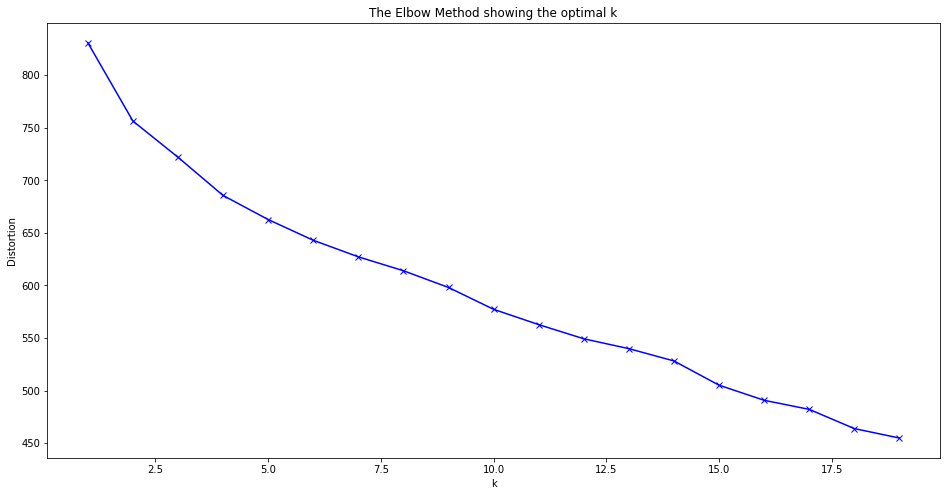

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

As we can see from the above graph, there is no sure way of determining the best no of clusters, since the graph is almost linear.

# Silhouette ,C-H and D-B Scores:

In [46]:
import numpy as numpy
import sklearn
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
range_n_clusters = list (range(2,35))


for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(X)
    centers = clusterer.cluster_centers_
    labels = clusterer.labels_

    score = metrics.silhouette_score(X, labels,metric='euclidean')
    score2= metrics.calinski_harabasz_score(X, labels)
    score3=metrics.davies_bouldin_score(X, labels)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    print()
    print("For n_clusters = {}, calinski harabasz score is {})".format(n_clusters, score2))
    print()
    print("For n_clusters = {}, DB score is {})".format(n_clusters, score3))
    print()
    print()

For n_clusters = 2, silhouette score is 0.16783930866534974)

For n_clusters = 2, calinski harabasz score is 9.467801262359652)

For n_clusters = 2, DB score is 2.486487966839616)


For n_clusters = 3, silhouette score is 0.08388695956372075)

For n_clusters = 3, calinski harabasz score is 7.2574613359210645)

For n_clusters = 3, DB score is 3.3763399007023502)


For n_clusters = 4, silhouette score is 0.09210174109567984)

For n_clusters = 4, calinski harabasz score is 6.626370304567607)

For n_clusters = 4, DB score is 2.8875904839119686)


For n_clusters = 5, silhouette score is 0.03669675273484297)

For n_clusters = 5, calinski harabasz score is 5.388724785702261)

For n_clusters = 5, DB score is 2.785899549975271)


For n_clusters = 6, silhouette score is 0.12729062512331962)

For n_clusters = 6, calinski harabasz score is 5.231964802805547)

For n_clusters = 6, DB score is 2.3328826643654383)


For n_clusters = 7, silhouette score is 0.07734217663455174)

For n_clusters = 7, cali

The higher the Silhoutte and calinski harabasz score the better. Whereas the lower the davies bouldin score the better. Judging by the above results, n_clusters= 11 seems to be good balance.

Thus I chose to cluster the neighborhoods into 11 groups

In [47]:
from sklearn.cluster import KMeans
kclusters = 10 #randomly selected cluster numbers for now

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# checking cluster labels 
kmeans.labels_

array([1, 3, 1, 7, 0, 1, 1, 0, 1, 0, 0, 2, 0, 0, 0, 3, 8, 0, 1, 1, 1, 0,
       7, 0, 0, 6, 8, 0, 0, 1, 0, 8, 0, 8, 0, 1, 8, 9, 1, 8, 2, 2, 0, 3,
       1, 1, 1, 0, 8, 3, 1, 1, 1, 1, 0, 0, 0, 2, 0, 8, 2, 2, 0, 1, 0, 1,
       1, 8, 1, 1, 5, 2, 0, 3, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 4, 1,
       5, 8, 8, 8, 5, 1, 2, 1, 1, 8], dtype=int32)

# Assign Cluster Labels to the Neighborhoods

In [48]:
neighborhoods_venues_sorted.insert(0, 'Cluster Label', kmeans.labels_)
neighborhoods_venues_sorted.head(10)

Cluster Label                                     Neighborhood  \
0               1                                  Willowdale East   
1               3                                        Agincourt   
2               1                                         Ancaster   
3               7  Bathurst Manor, Wilson Heights, Downsview North   
4               0                                  Bayview Village   
..            ...                                              ...   
93              1                                  Willowdale West   
94              2                                           Woburn   
95              1                                 Woodbine Heights   
96              1                                  York Mills West   
97              8                                York South-Weston   

     1st Most Common Venue 2nd Most Common Venue     3rd Most Common Venue  \
0              Coffee Shop                  Bank       Japanese Restaurant   
1       Chinese Restaurant         Shopping Mall      Cantonese Restaurant   
2                     Park    Turkish Restaurant               Coffee Shop   
3       Athletics & Sports  Gym / Fitness Center  Mediterranean Restaurant   
4   Furniture / Home Store                  Café               Coffee Shop   
..                     ...                   ...                       ...   
93             Coffee Shop                  Bank       Japanese Restaurant   
94    Fast Food Restaurant           Pizza Place                      Park   
95             Pizza Place              Pharmacy                      Park   
96             Coffee Shop            Restaurant         Convenience Store   
97             Pizza Place                  Park               Coffee Shop   

        4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0               Grocery Store        Sandwich Place  Fast Food Restaurant   
1                  Restaurant                 Hotel          Noodle House   
2   Latin American Restaurant     Electronics Store    Italian Restaurant   
3              Sandwich Place            Shoe Store     French Restaurant   
4              Clothing Store                  Bank         Moving Target   
..                        ...                   ...                   ...   
93              Grocery Store        Sandwich Place  Fast Food Restaurant   
94             Sandwich Place        Discount Store      Department Store   
95            Thai Restaurant                   Pub                   Spa   
96               Intersection      Business Service            Food Court   
97           Asian Restaurant           Supermarket              Bus Line   

   7th Most Common Venue 8th Most Common Venue      9th Most Common Venue  \
0       Ramen Restaurant           Pizza Place  Middle Eastern Restaurant   
1      Korean Restaurant           Karaoke Bar                Gas Station   
2     Chinese Restaurant     Other Repair Shop               Intersection   
3      Recreation Center      Basketball Court                Coffee Shop   
4     Chinese Restaurant          Liquor Store       Fast Food Restaurant   
..                   ...                   ...                        ...   
93      Ramen Restaurant           Pizza Place  Middle Eastern Restaurant   
94           Coffee Shop         Grocery Store                       Bank   
95          Skating Rink        Breakfast Spot               Liquor Store   
96     French Restaurant        Sandwich Place                       Park   
97            Restaurant           Golf Course             Massage Studio   

   10th Most Common Venue  
0        Sushi Restaurant  
1                    Bank  
2                    Café  
3             Gas Station  
4                     Spa  
..                    ...  
93       Sushi Restaurant  
94       Czech Restaurant  
95                   Café  
96            Golf Course  
97   Fast Food Restaurant  

[98 rows x 12 columns]

Joining dataframes to create one final dataFrame 'toronto'

# Final Dataframe:

In [49]:
toronto=df1
toronto=toronto.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
#toronto.drop('Unnamed: 0',axis=1)
toronto.head(10)
#toronto=toronto.drop(toronto.index[11])


Postal Code           Borough  \
0          M3A        North York   
1          M4A        North York   
2          M5A  Downtown Toronto   
3          M6A        North York   
4          M7A  Downtown Toronto   
5          M9A         Etobicoke   
6          M1B       Scarborough   
7          M3B        North York   
8          M4B         East York   
9          M5B  Downtown Toronto   
10         M6B        North York   
11         M9B         Etobicoke   
12         M1C       Scarborough   
13         M3C        North York   
14         M4C         East York   
15         M5C  Downtown Toronto   
16         M9C         Etobicoke   
17         M1E       Scarborough   
18         M5E  Downtown Toronto   
19         M1G       Scarborough   
20         M4G         East York   
21         M5G  Downtown Toronto   
22         M6G  Downtown Toronto   
23         M1H       Scarborough   
24         M2H        North York   
25         M3H        North York   
26         M4H         East York   
27         M5H  Downtown Toronto   
28         M6H      West Toronto   
29         M1J       Scarborough   
30         M2J        North York   
31         M3J        North York   
32         M4J         East York   
33         M5J  Downtown Toronto   
34         M6J      West Toronto   
35         M1K       Scarborough   
36         M2K        North York   
37         M3K        North York   
38         M4K      East Toronto   
39         M5K  Downtown Toronto   
40         M6K      West Toronto   
41         M1L       Scarborough   
42         M2L        North York   
43         M3L        North York   
44         M5L  Downtown Toronto   
45         M6L        North York   
46         M9L        North York   
47         M1M       Scarborough   
48         M2M        North York   
49         M3M        North York   
50         M4M      East Toronto   
51         M5M        North York   
52         M2N        North York   
53         M3N        North York   
54         M4N   Central Toronto   

                                         Neighborhood   latitude  longitude  \
0                                           Parkwoods  43.758800 -79.320197   
1                                    Victoria Village  43.732658 -79.311189   
2                           Regent Park, Harbourfront  43.660706 -79.360457   
3                    Lawrence Manor, Lawrence Heights  43.722079 -79.437507   
4         Queen's Park, Ontario Provincial Government  43.659659 -79.390340   
5             Islington Avenue, Humber Valley Village  43.679484 -79.538909   
6                                      Malvern, Rouge  43.809196 -79.221701   
7                                           Don Mills  43.775347 -79.345944   
8                     Parkview Hill, Woodbine Gardens  43.706298 -79.321907   
9                            Garden District, Ryerson  43.656500 -79.377114   
10                                          Glencairn  43.708712 -79.440685   
11  West Deane Park, Princess Gardens, Martin Grov...  43.663199 -79.568568   
12             Rouge Hill, Port Union, Highland Creek  43.780271 -79.130499   
13                                          Don Mills  43.775347 -79.345944   
14                                   Woodbine Heights  43.699930 -79.319132   
15                                     St. James Town  43.669403 -79.372704   
16  Eringate, Bloordale Gardens, Old Burnhamthorpe...  43.662273 -79.576516   
17                  Guildwood, Morningside, West Hill  43.755225 -79.198229   
18                                        Berczy Park  43.647984 -79.375396   
19                                             Woburn  43.759824 -79.225291   
20                                            Leaside  43.704798 -79.368090   
21                                 Central Bay Street  43.656119 -79.384670   
22                                           Christie  43.664111 -79.418405   
23                                          Cedarbrae  43.756467 -79.226692   
24         

In [50]:
toronto.to_csv(r'toronto.csv')